In [66]:
import numpy as np
import scipy
import rpy2
import more_itertools
import joblib
import argparse
import utils
import pylab as pl
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [36]:
from changepoint.mean_shift_model import MeanShiftModel

In [40]:
from argparse import ArgumentParser
import logging
import itertools
import os

from functools import partial
#from changepoint.ts_stats import ts_stats_significance
#from changepoint.ts_stats import parallelize_func

import sys
from os import path
from time import time
from glob import glob
from functools import partial
#import cPickle as pickle

from joblib import Parallel, delayed

__author__ = "Vivek Kulkarni"
__email__ = "viveksck@gmail.com"

LOGFORMAT = "%(asctime).19s %(levelname)s %(filename)s: %(lineno)s %(message)s"

"""ts_stats"""

LOGFORMAT = "%(asctime).19s %(levelname)s %(filename)s: %(lineno)s %(message)s"


def parallelize_func(iterable, func, chunksz=1, n_jobs=16, *args, **kwargs):
    """ Parallelize a function over each element of an iterable. """
    chunker = func
    chunks = more_itertools.chunked(iterable, chunksz)
    chunks_results = Parallel(n_jobs=n_jobs, verbose=50)(
        delayed(chunker)(chunk, *args, **kwargs) for chunk in chunks)
    results = more_itertools.flatten(chunks_results)
    return list(results)

# Code taken from: http://nbviewer.ipython.org/github/pv/SciPy-CookBook/blob/master/ipython/SignalSmooth.ipynb
def smooth(x, window_len=11, window='hanning'):
    """ Smoothen a time series. """
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[2 * x[0] - x[window_len - 1::-1],
              x, 2 * x[-1] - x[-1:-window_len:-1]]
    if window == 'flat':  # moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')
    y = np.convolve(w / w.sum(), s, mode='same')
    return y[window_len:-window_len + 1]


def ts_stats_significance(ts, ts_stat_func, null_ts_func, B=1000, permute_fast=False):
    """ Compute  the statistical significance of a test statistic at each point
        of the time series.
    """
    stats_ts = ts_stat_func(ts)
    if permute_fast:
        # Permute it in 1 shot
        null_ts = map(np.random.permutation, np.array([ts, ] * B))
    else:
        null_ts = np.vstack([null_ts_func(ts) for i in np.arange(0, B)])
    stats_null_ts = np.vstack([ts_stat_func(nts) for nts in null_ts])
    pvals = []
    nums = []
    for i in np.arange(0, len(stats_ts)):
        num_samples = np.sum((stats_null_ts[:, i] >= stats_ts[i]))
        nums.append(num_samples)
        pval = num_samples / float(B)
        pvals.append(pval)

    return stats_ts, pvals, nums

# Code below taken from http://nbviewer.ipython.org/github/welch/stats-notebooks/blob/master/SubsamplingBootstrap.ipynb
def bootstrap_ts(y, func, B=1000, b=3):
    """ Bootstrap a timeseries using a window size:b. """
    beta_star = np.empty(B)
    z = y
    z_star = np.empty(len(z))
    for boot_i in range(B):
        for block_i, start in enumerate(np.random.randint(len(z) - b + 1, size=len(z) / b)):
            z_star[block_i * b:(block_i + 1) * b] = z[start:start + b]
            beta_star[boot_i] = func(z_star)
    return beta_star


def get_ci(theta_star, blockratio=1.0):
    """ Get the confidence interval. """
    # get rid of nans while we sort
    b_star = np.sort(theta_star[~np.isnan(theta_star)])
    se = np.std(b_star) * np.sqrt(blockratio)
    # bootstrap 95% CI based on empirical percentiles
    ci = [b_star[int(len(b_star) * .025)], b_star[int(len(b_star) * .975)]]
    return ci


def get_pvalue(value, ci):
    """ Get the p-value from the confidence interval."""
    from scipy.stats import norm
    se = (ci[1] - ci[0]) / (2.0 * 1.96)
    z = value / se
    pvalue = -2 * norm.cdf(-np.abs(z))
    return pvalue


def ts_stats_significance_bootstrap(ts, stats_ts, stats_func, B=1000, b=3):
    """ Compute  the statistical significance of a test statistic at each point
        of the time series by using timeseries boootstrap.
    """
    pvals = []
    for tp in np.arange(0, len(stats_ts)):
        pf = partial(stats_func, t=tp)
        bs = bootstrap_ts(ts, pf, B=B, b=b)
        ci = get_ci(bs, blockratio=b / len(stats_ts))
        pval = abs(get_pvalue(stats_ts[tp], ci))
        pvals.append(pval)
    return pvals

"""Mean shift """


class MeanShiftModel(object):

    def get_ts_stats_significance(self, x, ts, stat_ts_func, null_ts_func, B=1000, permute_fast=False, label_ts=''):
        """ Returns the statistics, pvalues and the actual number of bootstrap
            samples. """
        stats_ts, pvals, nums = ts_stats_significance(
            ts, stat_ts_func, null_ts_func, B=B, permute_fast=permute_fast)
        return stats_ts, pvals, nums

    def generate_null_timeseries(self, ts, mu, sigma):
        """ Generate a time series with a given mu and sigma. This serves as the
        NULL distribution. """
        l = len(ts)
        return np.random.normal(mu, sigma, l)

    def shuffle_timeseries(self, ts):
        """ Shuffle the time series. This also can serve as the NULL distribution. """
        return np.random.permutation(ts)

    def compute_balance_mean(self, ts, t):
        """ Compute the balance. The right end - the left end."""
        """ For changed words we expect an increase in the mean, and so only 1 """
        return np.mean(ts[t + 1:]) - np.mean(ts[:t + 1])

    def compute_balance_mean_ts(self, ts):
        """ Compute the balance at each time 't' of the time series."""
        balance = [self.compute_balance_mean(ts, t) for t in np.arange(0, len(ts) - 1)]
        return balance

    def compute_balance_median(self, ts, t):
        """ Compute the balance at either end."""
        return np.median(ts[t + 1:]) - np.median(ts[:t + 1])

    def compute_balance_median_ts(self, ts):
        """ Compute the balance at each time 't' of the time series."""
        balance = [self.compute_balance_median(ts, t) for t in np.arange(0, len(ts) - 1)]
        return balance

    def compute_cusum_ts(self, ts):
        """ Compute the Cumulative Sum at each point 't' of the time series. """
        mean = np.mean(ts)
        cusums = np.zeros(len(ts))
        cusum[0] = (ts[0] - mean)
        for i in np.arange(1, len(ts)):
            cusums[i] = cusums[i - 1] + (ts[i] - mean)

        assert(np.isclose(cumsum[-1], 0.0))
        return cusums

    def detect_mean_shift(self, ts, B=1000):
        """ Detect mean shift in a time series. B is number of bootstrapped
            samples to draw.
        """
        x = np.arange(0, len(ts))
        stat_ts_func = self.compute_balance_mean_ts
        null_ts_func = self.shuffle_timeseries
        stats_ts, pvals, nums = self.get_ts_stats_significance(x, ts, stat_ts_func, null_ts_func, B=B, permute_fast=True)
        return stats_ts, pvals, nums

    def test(self):
        print ("Testing a time series with a significant mean shift")
        ts = np.hstack([np.random.normal(0.0, 1.0, 50), np.random.normal(5.0, 1.0, 50)])
        x = np.arange(0, len(ts))
        stat_ts_func = self.compute_balance_mean_ts
        print ("Using NULL")
        null_ts_func = partial(self.generate_null_timeseries, mu=0.0, sigma=1.0)
        stats_ts, pvals, nums = self.get_ts_stats_significance(
            x, ts, stat_ts_func, null_ts_func,
            label_ts='test', B=1000)
        print ("Minimum p-value is {}".format(np.min(pvals)))

        print ("Using permutation")
        null_ts_func = self.shuffle_timeseries
        stats_ts, pvals, nums = self.get_ts_stats_significance(x, ts, stat_ts_func, null_ts_func, label_ts='test', B=1000)
        print ("Minimum p-value is {}".format(np.min(pvals)))

        print ("************************************************************************")

        print ("Testing a time series with no mean shift")
        ts = np.random.normal(0.0, 0.000001, 1000)
        x = np.arange(0, len(ts))
        stat_ts_func = self.compute_balance_mean_ts
        print ("Using NULL")
        null_ts_func = partial(self.generate_null_timeseries, mu=0.0, sigma=1.0)
        stats_ts, pvals, nums = self.get_ts_stats_significance(x, ts, stat_ts_func, null_ts_func, label_ts='test', B=1000)
        print ("Minimum p-value is {}".format(np.min(pvals)))

        print ("Using permutation")
        null_ts_func = self.shuffle_timeseries
        stats_ts, pvals, nums = self.get_ts_stats_significance(x, ts, stat_ts_func, null_ts_func, label_ts='test', B=1000)
        print ("Minimum p-value is {}".format(np.min(pvals)))


In [125]:
dfCOstat=pd.read_csv('dfstatCO.csv')
dfNOxstat=pd.read_csv('dfstatNOx.csv')
dfPM10stat=pd.read_csv('dfstatPM10.csv')
dfPM2stat=pd.read_csv('dfstatPM2.csv')

In [137]:
datelimax='2015-12-01'
datelimin='2016-01-01'

In [138]:
COstat=dfCOstat[(dfCOstat.date>=datelimax)&(dfCOstat.date<datelimin)].reset_index().statCO
NOxstat=dfNOxstat[(dfNOxstat.date>=datelimax)&(dfNOxstat.date<datelimin)].reset_index().statCO
PM10stat=dfPM10stat[(dfPM10stat.date>=datelimax)&(dfPM10stat.date<datelimin)].reset_index().statCO
PM2stat=dfPM2stat[(dfPM2stat.date>=datelimax)&(dfPM2stat.date<datelimin)].reset_index().statCO

In [139]:
stats_CO, pvals_CO, nums_CO = model.detect_mean_shift(COstat, B=1000)
stats_NOx, pvals_NOx, nums_NOx = model.detect_mean_shift(NOxstat, B=1000)
stats_PM10, pvals_PM10, nums_PM10 = model.detect_mean_shift(PM10stat, B=1000)
stats_PM2, pvals_PM2, nums_PM2 = model.detect_mean_shift(PM2stat, B=1000)

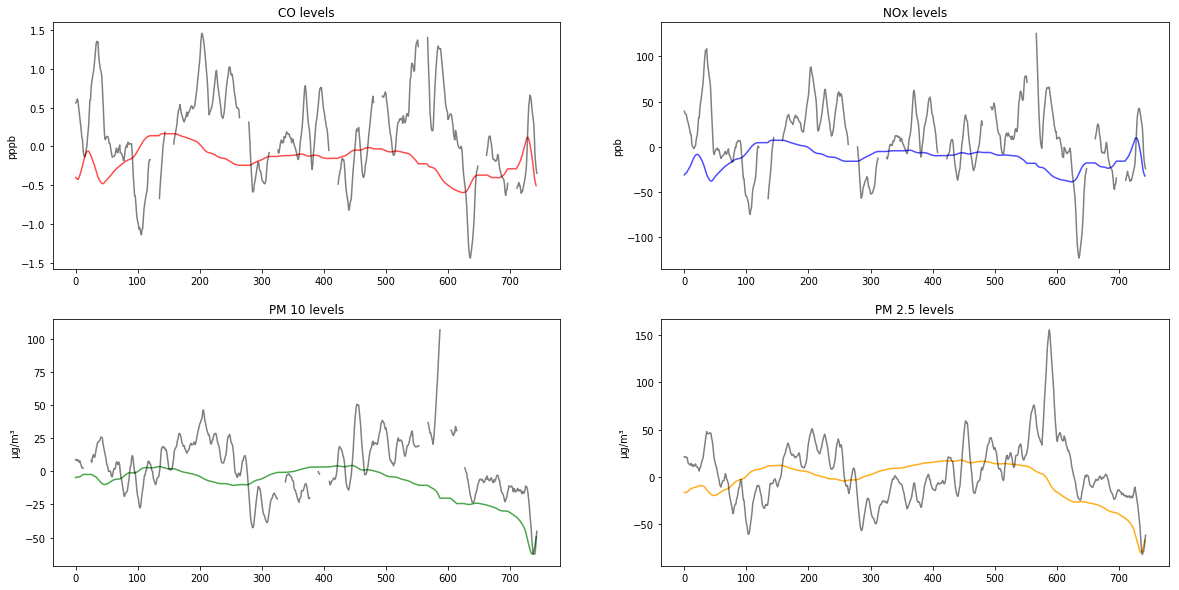

In [140]:
fig = pl.figure(figsize = (20 ,10))
ax0,ax1,ax2,ax3 = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223),fig.add_subplot(224)
ax0.plot(stats_CO,'r',alpha=0.7)
ax1.plot(stats_NOx,'b',alpha=0.7)
ax2.plot(stats_PM10,'g',alpha=0.7)
ax3.plot(stats_PM2,'Orange',alpha=0.9)
ax0.plot(COstat,'k',alpha=0.5)
ax1.plot(NOxstat,'k',alpha=0.5)
ax2.plot(PM10stat,'k',alpha=0.5)
ax3.plot(PM2stat,'k',alpha=0.5)
ax0.set_title('CO levels')
ax1.set_title('NOx levels')
ax2.set_title('PM 10 levels')
ax3.set_title('PM 2.5 levels')
ax0.set_ylabel('pppb')
ax1.set_ylabel('ppb')
ax2.set_ylabel('µg/m³')
ax3.set_ylabel('µg/m³')